# Using Census Data

This notebook describes the basis of how to work with data from the U.S. census.

It requires two additional packages that are not available through Conda:

    pip install census us
    
## API Key

In order to use the census data, you will need a Census API key. Request one here (provide your e-mail address): https://api.census.gov/data/key_signup.html

## Setup

Let's start with imports as usual:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from census import Census
from us import states

And set up a census object (replace API KEY with your API key):

In [2]:
c = Census('<put key here>')

## Census Data

The census data comes in a variety of *files*. These files include:

- `sf1` — Summary File 1, containing complete count information on the *decennial* census.
- `acs1` — American Community Survey, a supplementary annual survey of a sample of the population carried out by the census bureau every year.

Both of these files are accessed in the same way, via the Census object, but they contain different variables.  Each contains thousands of variables.

This notebook focuses on the SF1 file. The [variable list](https://api.census.gov/data/2010/dec/sf1/variables.html) describes these variables, and the ones of interest are all reported as **population counts**.  That means variable `P012001` is the number of people in a geographic area.

To fetch data, we need to know three things:

- The *geographic level* we want: county or state?
- *Which* geographic area(s)?
- The variables to retrieve.
- The year. We're going to use 2010.

Variables in turn are nested. Many variables are estimated population counts; for these, one variable is the total population, and others are counts within subgroups.  Look at the variable list to see how these are described:

- `P012001` is the estimated total population
- `P012002` is the estimated male population
- `P012026` is the estimated female population

There are variables for a *lot* of different breakdowns.

The API returns a list of dictionaries containing the variables.  Let's get the gender population estimate for Idaho:

In [3]:
c.sf1.state(('NAME', 'P012001', 'P012002', 'P012026'), states.ID.fips, year=2010)

[{'NAME': 'Idaho',
  'P012001': 1567582.0,
  'P012002': 785324.0,
  'P012026': 782258.0,
  'state': '16'}]

Regions are identified by **FIPS codes**: numeric codes that identify states and counties.  Each state has a 2-digit FIPS code, and the `us.states` module lets us look up a state's FIPS code.  (We can also get a [table of them](https://www.census.gov/library/reference/code-lists/ansi/ansi-codes-for-states.html).)

Each county's code is a 5-digit number: its state code, followed by 3 digits to identify the county.

When calling `state`, we can provide `'*'` instead of a FIPS code to request all states, and use Pandas `from_records` to make a data frame from the dictionaries:

In [4]:
gender_pop = pd.DataFrame.from_records(
    c.sf1.state(('NAME', 'P012001', 'P012002', 'P012026'), '*', year=2010)
)
gender_pop.head()

,NAME,P012001,P012002,P012026,state
0,Alabama,4779736.0,2320188.0,2459548.0,01
1,Alaska,710231.0,369628.0,340603.0,02
2,Arizona,6392017.0,3175823.0,3216194.0,04
3,Arkansas,2915918.0,1431637.0,1484281.0,05
4,California,37253956.0,18517830.0,18736126.0,06


In [5]:
gender_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   NAME     52 non-null     object 
 1   P012001  52 non-null     float64
 2   P012002  52 non-null     float64
 3   P012026  52 non-null     float64
 4   state    52 non-null     object 
dtypes: float64(3), object(2)
memory usage: 2.2+ KB


These variable names are not very meaningful. Let's rename them and compute a fraction of the population that is female:

In [6]:
gender_pop = gender_pop.rename(columns={
    'P012001': 'TotalPop',
    'P012002': 'MalePop',
    'P012026': 'FemalePop'
})
gender_pop['FemaleFrac'] = gender_pop['FemalePop'] / gender_pop['TotalPop']

Let's look at the distribution of that over states:

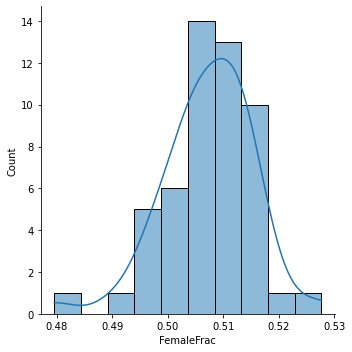

In [7]:
sns.displot(x=gender_pop['FemaleFrac'], kde=True)

## County Level

The `c.acs1.state_county` method fetches county-level data.  For example, to get all counties in Idaho:

In [8]:
id_county_pop = pd.DataFrame.from_records(
    c.sf1.state_county(('NAME', 'P012001', 'P012002', 'P012026'), states.ID.fips, '*', year=2010)
).rename(columns={
    'P012001': 'TotalPop',
    'P012002': 'MalePop',
    'P012026': 'FemalePop'
})
id_county_pop.head()

,NAME,TotalPop,MalePop,FemalePop,state,county
0,"Bear Lake County, Idaho",5986.0,2972.0,3014.0,16,007
1,"Benewah County, Idaho",9285.0,4732.0,4553.0,16,009
2,"Ada County, Idaho",392365.0,196501.0,195864.0,16,001
3,"Adams County, Idaho",3976.0,2041.0,1935.0,16,003
4,"Bannock County, Idaho",82839.0,41298.0,41541.0,16,005


What does the distribution of total population look like?

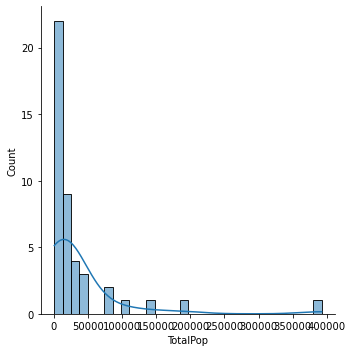

In [9]:
sns.displot(x='TotalPop', data=id_county_pop, kde=True)

You can provide `'*'` for both state and county, to get all counties in the US (for which data is available).

Look at education and income at the county level!

In [10]:
county_pop = pd.DataFrame.from_records(
    c.sf1.state_county(('NAME', 'P012001', 'P012002', 'P012026'), states.ID.fips, '*', year=2010)
).rename(columns={
    'B01001_001E': 'TotalPop',
    'B01001_002E': 'MalePop',
    'B01001_026E': 'FemalePop'
})
county_pop.head()

,NAME,P012001,P012002,P012026,state,county
0,"Bear Lake County, Idaho",5986.0,2972.0,3014.0,16,007
1,"Benewah County, Idaho",9285.0,4732.0,4553.0,16,009
2,"Ada County, Idaho",392365.0,196501.0,195864.0,16,001
3,"Adams County, Idaho",3976.0,2041.0,1935.0,16,003
4,"Bannock County, Idaho",82839.0,41298.0,41541.0,16,005


## ACS1

The ACS data works exactly the same, except it has a different set of variables available.  It also reports *estimates* instead of full counts: the ACS surveys a sample, and uses that to estimate population counts.  It is also missing data for a lot of counties, where there is not sufficient sample data to estimate population counts.

The variables ending in `E` are estimates.  Additional variables can be used to access estimates of the precision of these estimates.

## Conclusion

There are a lot of things you can do with census data.  For further reading, see:

- [The ACS1 2014 variable list](https://api.census.gov/data/2014/acs/acs5/variables.html)
- [The SF1 2010 variable list](https://api.census.gov/data/2010/dec/sf1/variables.html)
- The [Social Explorer](https://www.socialexplorer.com/data/ACS2014_5yr/metadata/), a nicer interface for browsing census data.

:::{tip}
The Social Explorer has a very good [database of census fields](https://www.socialexplorer.com/data/ACS2014_5yr/metadata/?ds=ACS14_5yr).
This database describes all the census sub-tables, and lets you browse them by group (e.g. B05010).

Within the page for a group, such as [B05010](https://www.socialexplorer.com/data/ACS2014_5yr/metadata/?ds=ACS14_5yr&table=B05010), there
is a list of all the sub-variables, organized hierarchically so you can see how they relate to each other.
The variable names do need a bit of modification; when Social Explorer says `B05010001`, you need to request that from the census as `B05010_001E` (the Estimated value).
The census API puts an underscore (`_`) between th evariable group code (`B05010`) and the specific sub-variable identifier (`001E`); Social Explorer does not include the underscore.

The explorer also includes excerpts from the full census technical documentation providing more detail about the different variables and their codings.
:::